# Real Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from transformers import BertTokenizer
import time


pd.set_option("mode.copy_on_write", True)

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

#### Loading the data

In [2]:
Dataset = pd.read_csv(
    "https://raw.githubusercontent.com/halfmoonliu/InjuryNoteLabel/main/Data/full_dataset.csv"
)

In [3]:
train_df_real = pd.read_csv(
    "https://raw.githubusercontent.com/halfmoonliu/InjuryNoteLabel/main/Data/TrainSetReal.csv"
)
test_df_real = pd.read_csv(
    "https://raw.githubusercontent.com/halfmoonliu/InjuryNoteLabel/main/Data/TestSetReal.csv"
)
dev_df_real = pd.read_csv(
    "https://raw.githubusercontent.com/halfmoonliu/InjuryNoteLabel/main/Data/DevSetReal.csv"
)

#### EDA to find the most common categories in the Event column

In [4]:
Dataset.event.nunique()

48

In [5]:
Dataset.event.value_counts()

event
71    38673
62    36421
42    23320
55    17421
63    13520
60    13406
11    13337
73    12409
43     9776
70     7933
64     6540
53     5817
13     4861
66     4289
26     4017
12     3338
41     2257
99     2050
24     1517
31     1347
78     1326
27     1260
72     1141
51      741
52      708
44      556
32      494
23      423
25      146
69      144
67       90
61       78
22       76
40       76
65       73
21       55
49       40
50       39
45       22
20       19
79       18
54       15
56        9
59        7
74        7
10        4
30        2
29        2
Name: count, dtype: int64

In [6]:
# calculating the most common event in the dataset and how much it accounts for.

(len(Dataset[Dataset.event == 71]) / len(Dataset.event)) * 100

16.827517187364023

In [7]:
# calculating the most common event in the dataset and how much it accounts for.

(len(Dataset[Dataset.event == 62]) / len(Dataset.event)) * 100

15.847619876425028

In [8]:
# Calculating the least commont occurance in the dataset

(len(Dataset[Dataset.event == 30]) / len(Dataset.event)) * 100

0.0008702462796971543

In [9]:
# counting the events and values and creating a plot

event = Dataset.event.value_counts().index
event_labels = list(map(str, event))
event_counts = Dataset.event.value_counts().values

#### Viewing the Distribution of the dataset

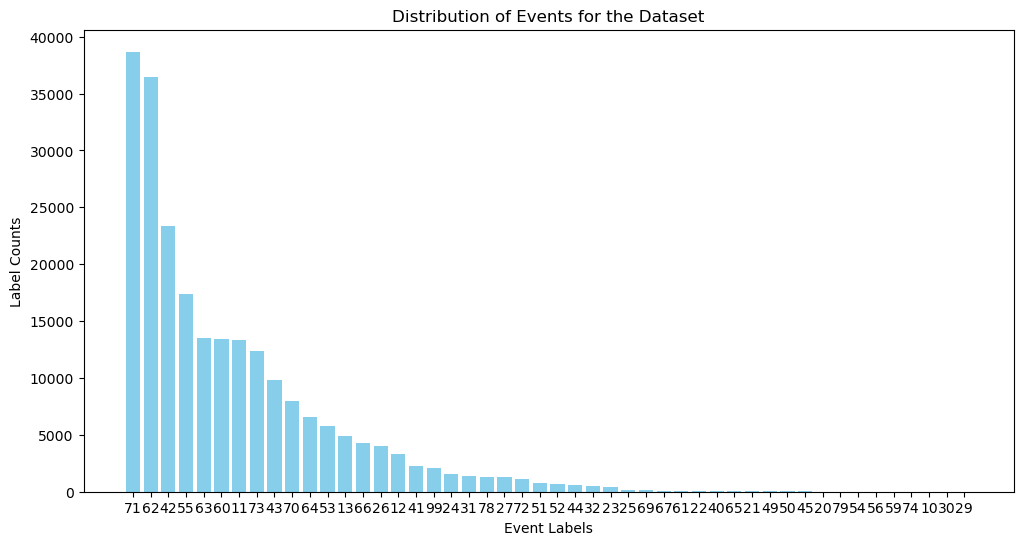

In [10]:
# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(event_labels, event_counts, color="skyblue")
plt.xlabel("Event Labels")
plt.ylabel("Label Counts")
plt.title("Distribution of Events for the Dataset")
plt.show()

In [11]:
len(event_labels)

48

### Tokenisation
The next step is to tokenize the documents, or individual injury report in this project. After tokenization, naratives become lists of words. We use the **BERT pretrained tokenizer**, provided by **Hugging face**. Below is an illustrating example.

In [12]:
# load pretrained tokenizer
PRE_TRAINED_MODEL_NAME = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [13]:
# an illustrating example of input/ output of tokenizer
sample_txt = "When was I last outside? I am stuck at home for 2 weeks."
tokens_sample = tokenizer.tokenize(sample_txt)
token_ids_sample = tokenizer.convert_tokens_to_ids(tokens_sample)

print(f" Sentence: {sample_txt}")
print(f"   Tokens: {tokens_sample}")
print(f"Token IDs: {token_ids_sample}")

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


#### Create Training Corpus




In [14]:
# Create injury report corpus, i.e. list of lists of totokenized

train_report_l = train_df_real["text"].tolist()
training_corpus = [tokenizer.tokenize(report.lower()) for report in train_report_l]
print(len(training_corpus))
print(training_corpus[0])

183856
['47', 'yo', 'female', 'dropped', 'p', '##alle', '##t', 'on', 'foot', 'at', 'work', 'd', '##x', 'toe', 'injury', 'b']


In [15]:
# create training vocab dictionary

tok_ind = 0  # numbering for dictionary
tok_id_d = dict()  # map token to token_ind
id_tok_d = dict()  # map token_ind to token

# looping over the training corpus
for si in range(len(training_corpus)):
    # loop over tokens in the sentence
    for tok in training_corpus[si]:
        # update vocab dict
        if tok not in tok_id_d:
            tok_id_d[tok] = tok_ind
            id_tok_d[tok_ind] = tok
            # update token index
            tok_ind += 1
tok_id_d["UNK"] = tok_ind
id_tok_d[tok_ind] = "UNK"

In [16]:
# get vocab length

all_toks = id_tok_d.keys()
print("length of the vocabulary:")
print(len(all_toks))
print(tok_id_d["UNK"])
print(id_tok_d[10418])

length of the vocabulary:
10419
10418
UNK


#### Prepare dataset

In [17]:
def MapTokInd(tok, tokMap):
    if tok in tokMap:
        return tokMap[tok]
    else:
        return tokMap["UNK"]

In [18]:
# create x_train, y_train
train_corpus_frag = training_corpus
x_train = np.empty((len(train_corpus_frag), len(all_toks)))
y_train = train_df_real["event"].to_numpy()

# looping over the training corpus
for si in range(len(train_corpus_frag)):
    word_count_sent = np.zeros(len(all_toks))
    # loop over tokens in the sentence
    for tok in training_corpus[si]:
        tokInd = MapTokInd(tok, tok_id_d)
        word_count_sent[tokInd] += 1
    x_train[si] = word_count_sent

In [19]:
# # create x_train, y_train
# train_corpus_frag = training_corpus[:100000]
# x_train = np.empty((len(train_corpus_frag), len(all_toks)))
# y_train = train_df_real["event"].to_numpy()[:100000]

# # looping over the training corpus
# for si in range(len(train_corpus_frag)):
#     word_count_sent = np.zeros(len(all_toks))
#     # loop over tokens in the sentence
#     for tok in training_corpus[si]:
#         tokInd = MapTokInd(tok, tok_id_d)
#         word_count_sent[tokInd] += 1
#     x_train[si] = word_count_sent

#### Fitting the dataset

In [20]:
NBModel = MultinomialNB()

start_time = time.time()

NBModel.fit(x_train, y_train)

# Record the end time
end_time = time.time()

# Calculate and print the time spent
elapsed_time = end_time - start_time
print(f"Time spent training the corpus: {elapsed_time} seconds")

Time spent training the corpus: 19.06555700302124 seconds


In [21]:
# Predict labels for the training data
y_train_pred = NBModel.predict(x_train)

# Calculate accuracy on the training data
train_accuracy = np.sum(y_train == y_train_pred) / x_train.shape[0] * 100

print("Training Accuracy:", round(train_accuracy, 2))

Training Accuracy: 75.02


#### Calculating the Test Corpus and accuracy

In [23]:
# Create test corpus
test_report_l = test_df_real["text"].tolist()
test_corpus = [tokenizer.tokenize(report.lower()) for report in test_report_l]
print(len(test_corpus))
print(test_corpus[0])

22982
['56', '##yo', '##f', 'with', 'hem', '##ato', '##ma', 'to', 'left', 'side', 'of', 'head', 'after', 'being', 'knocked', 'over', 'by', 'a', 'student', 'fell', 'and', 'hit', 'the', 'ground', 'at', 'school']


In [24]:
# creating the matrices for the test corpus and populating it with the words to form a matrix

x_test = np.empty((len(test_corpus), len(all_toks)))
y_test = test_df_real["event"].to_numpy()

# looping over the test corpus
for si in range(len(test_corpus)):
    word_count_sent = np.zeros(len(all_toks))
    # loop over tokens in the sentence
    for tok in test_corpus[si]:
        tokInd = MapTokInd(tok, tok_id_d)
        word_count_sent[tokInd] += 1
    x_test[si] = word_count_sent

In [26]:
# the PREDICTION is done using the TEST data
y_pred_test = NBModel.predict(x_test)

In [28]:
test_df_real["predictions"] = y_pred_test
test_df_real

,id,text,sex,age,event,event_ind,predictions
0,130643,56YOF WITH HEMATOMA TO LEFT SIDE OF HEAD AFTER...,2,56,12,2,11
1,79309,61YOM SLIPPED WHILE WALKING OFF TRACTOR AT WOR...,1,61,43,19,43
2,9307,18 YOF SUS PUNCTURE TO FINGER ACCIDENTALLY PIE...,2,18,60,31,60
3,179615,16 YOF IS A LIFEGUARD AT A POOL JUMPED IN THE...,2,16,44,20,73
4,18724,57YOF WORKS IN SURGERY WAS SITTING ON A STOOL ...,2,57,42,18,42
...,...,...,...,...,...,...,...
22977,148606,57YOM AT WORK WHEN A SHEET OF DRYWALL FELL ONT...,1,57,62,33,62
22978,17326,21YOM LIFTING STEEL AT WORK AND FELT LEFT SHOU...,1,21,71,41,71
22979,148941,55 YOF DX LOW BACK PAIN S P AFTER TRANFERRING...,2,55,71,41,71
22980,168538,33YOM W EPIGASTRIC PAIN S P TAKING NSAIDS ASA...,1,33,73,43,70


In [30]:
accuracy = np.sum(y_test == y_pred_test) / x_test.shape[0] * 100
round(accuracy, 2)

73.14

#### Dev Set predictions and Accuracy

In [32]:
dev_report_l = dev_df_real["text"].tolist()
dev_corpus = [tokenizer.tokenize(report.lower()) for report in dev_report_l]
print(len(dev_corpus))
print(dev_corpus[0])

22982
['34', '##yo', '##m', 'lifting', 'boxes', 'at', 'work', 'over', 'use', 'of', 'hand', 'd', '##x', 'car', '##pal', 'tunnel', 'syndrome']


In [34]:
x_test_dev = np.empty((len(dev_corpus), len(all_toks)))
y_test_dev = dev_df_real["event"].to_numpy()

# looping over the training corpus
for si in range(len(dev_corpus)):
    word_count_sent_dev = np.zeros(len(all_toks))
    # loop over tokens in the sentence
    for tok in dev_corpus[si]:
        tokInd = MapTokInd(tok, tok_id_d)
        word_count_sent_dev[tokInd] += 1
    x_test_dev[si] = word_count_sent_dev

In [35]:
# the PREDICTION is done using the TEST data

y_pred_dev = NBModel.predict(x_test_dev)

In [37]:
accuracy = np.sum(y_test_dev == y_pred_dev) / x_test_dev.shape[0] * 100
round(accuracy, 2)

73.13